In [1]:
import os
from datetime import datetime, timedelta
from contextlib import contextmanager

import psycopg2
import matplotlib.pyplot as plt

@contextmanager
def get_cursor():
    conn = psycopg2.connect(os.environ['DATABASE_URL'])
    cur = conn.cursor()
    
    try:
        yield cur
    finally:
        cur.close()
        conn.close()



In [2]:
with get_cursor() as cur:
    cur.execute('SELECT COUNT(*) FROM "Post";')
    print('Total posts: %d' % cur.fetchone())

    cur.execute('SELECT COUNT(*) FROM "User";')
    print('Total users: %d' % cur.fetchone()) 

Total posts: 293
Total users: 519


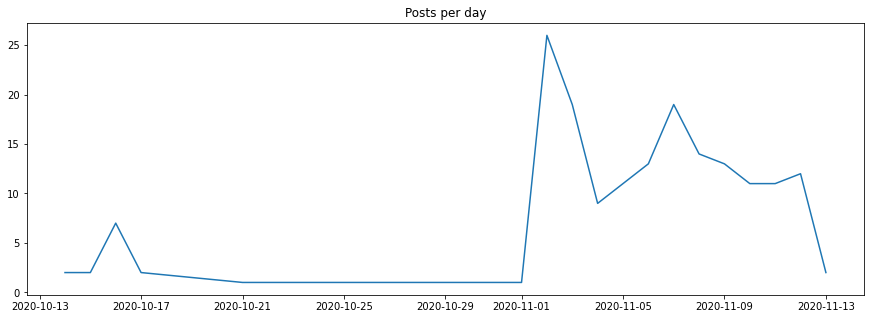

In [4]:
with get_cursor() as cur:
    cur.execute('''
        SELECT "createdAt"::DATE as date, COUNT(*) FROM "Post"
        WHERE "Post"."createdAt" > %s
        GROUP BY date
        ORDER BY date;
    ''', (datetime.utcnow() - timedelta(days=30),))
    rows = cur.fetchall()

    dates = [row[0] for row in rows]
    post_counts = [row[1] for row in rows]

    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,1,1)
    plt.title('Posts per day')
    plt.plot(dates, post_counts)
    plt.show()
